# Dataset
In the following we start using a dataset (from UCI Machine Learning repository). 
The dataset represents iris flowers. 
We would like to predict the class of the flowers according to the petal dimension. 
We have three class: 
- setosa (0)
- versicolor (1) 
- virginica (2)

In [1]:
from sklearn import tree
from sklearn.datasets import load_iris
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import graphviz

iris = load_iris()
X = iris.data
y = iris.target


## Artificial inflation

In [2]:
def get_data(label, dim, inflation):
    """
    Select a subset of samples of the class specified by label. 
    The subset dimension is defined in term of dim% of samples of the original dataset.
    The inflation parameter define the cost
    """
    size = len(iris.data) // 3 #Dimension for single class
    indexes = np.arange(size*label, size*(label+1)) #Indexes of the class to select
    np.random.shuffle(indexes)
    test_size = int((size * round(1.0 - dim, 1))) #test set size based on dim
    return np.repeat(indexes[:-test_size], inflation), indexes[-test_size:]

Scores
[0.96666667 1.         0.9        0.86666667 1.        ]


Mean of scores
0.9466666666666667


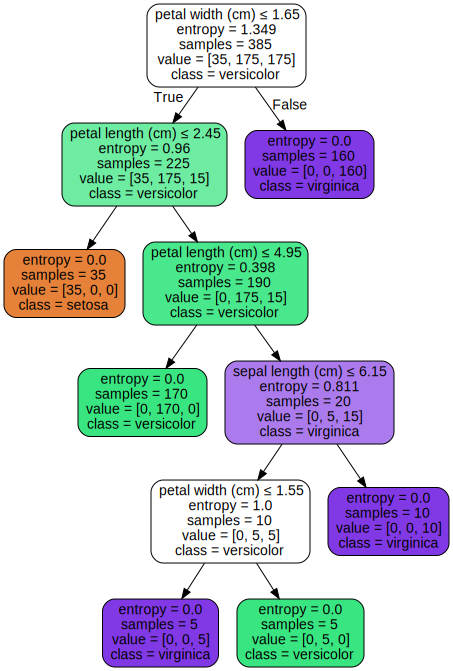

In [3]:
clf = tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=5,class_weight={0:1,1:1,2:1})

setosa_train, setosa_test = get_data(0, 0.7, 1)
versicolor_train, versicolor_test = get_data(1, 0.7, 5)
virginica_train, virginica_test = get_data(2, 0.7, 5)

indexes_train = np.concatenate([setosa_train, versicolor_train, virginica_train])
indexes_test = np.concatenate([setosa_test, versicolor_test, virginica_test])

np.random.shuffle(indexes_train)
np.random.shuffle(indexes_test)

iris_X_train = iris.data[indexes_train]
iris_y_train = iris.target[indexes_train]
iris_X_test = iris.data[indexes_test]
iris_y_test = iris.target[indexes_test]

clf = clf.fit(iris_X_train, iris_y_train)

#we pass the classifier, the dataset, the target and the number of partitions 
#we have differents combinations of examples in training and test set
scores = cross_val_score(clf, iris.data, iris.target, cv=5) # score will be the accuracy of each permutation 
print("Scores")
print(scores)
print("\n")
print("Mean of scores")
print(np.mean(scores, dtype=np.float64))

#Showing tree
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names, 
                         class_names=iris.target_names, 
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## Weighting the classess
We first weigh more versicolor and then viriginca.

When we weigh more versicolor as result we have that versicolor is preferred over setosa and virginica, because an error on versicolor would cost 10 times more than an error on setosa or virginica.


Scores
[0.93333333 0.9        0.9        0.93333333 0.93333333]


Mean of scores
0.9200000000000002


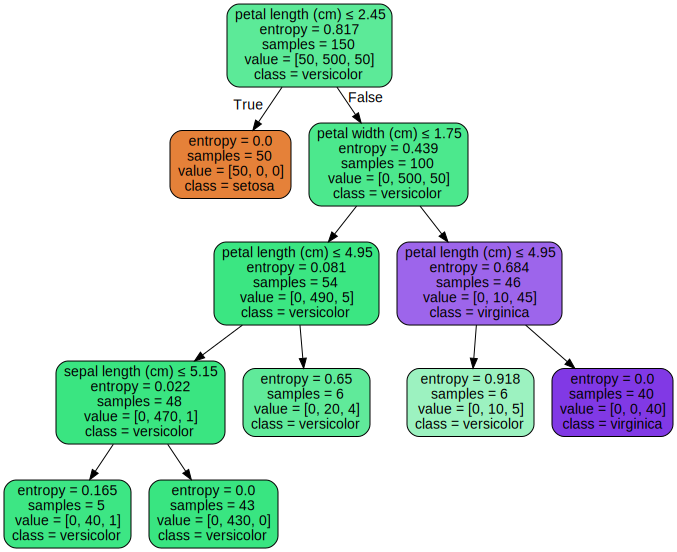

In [4]:
#versicolor weigh 10 more than virginica
clf = tree.DecisionTreeClassifier(criterion="entropy", random_state=300, min_samples_leaf = 5, class_weight={0:1,1:10,2:1})
clf = clf.fit(iris.data, iris.target)
#we pass the classifier, the dataset, the target and the number of partitions 
#we have differents combinations of examples in training and test set
scores = cross_val_score(clf, iris.data, iris.target, cv=5) # score will be the accuracy of each permutation 
print("Scores")
print(scores)
print("\n")
print("Mean of scores")
print(np.mean(scores, dtype=np.float64))

#Showing tree
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names, 
                         class_names=iris.target_names, 
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

Viceversa, when we weigh more virginica as result we have that virginica is preferred over setosa and versicolor, because an error on virginica would cost 10 times more than an error on setosa or veriscolor.

Scores
[0.93333333 0.93333333 0.86666667 0.83333333 0.93333333]


Mean of scores
0.9


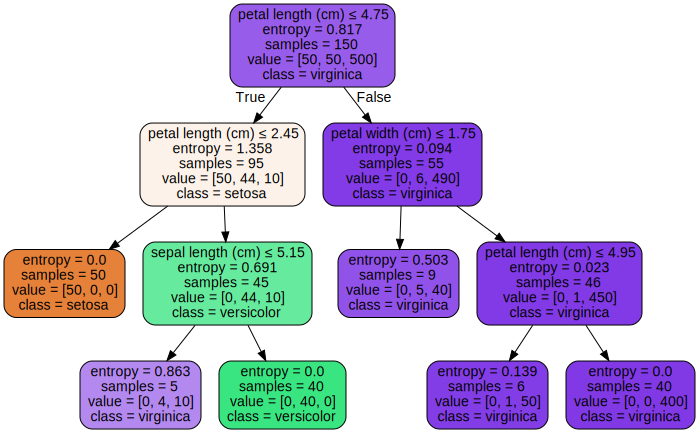

In [5]:
#virginica weigh 10 more than versicolor
clf = tree.DecisionTreeClassifier(criterion="entropy", random_state=300, min_samples_leaf = 5, class_weight={0:1,1:1,2:10})
clf = clf.fit(iris.data, iris.target)
#we pass the classifier, the dataset, the target and the number of partitions 
#we have differents combinations of examples in training and test set
scores = cross_val_score(clf, iris.data, iris.target, cv=5) # score will be the accuracy of each permutation 
print("Scores")
print(scores)
print("\n")
print("Mean of scores")
print(np.mean(scores, dtype=np.float64))

#Showing tree
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names, 
                         class_names=iris.target_names, 
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## Avoid overfitting
We consider different values for:
- **max_depth:** the maximum depth of the tree
- **min_sample_leaf:** the minimum number of samples required to be at a leaf node.
- **min_sample_split:** the minimum number of samples required to split an internal node

We will choose, based on validation curve for each hyperparameter, which is the best combination of hyperparameters

Considering different values for **max_depth** we can see from the validation curve that increasing the depth doesn't improve the accuracy. Since is better to have simple tree, we prefer to set **max_depth** to lower value, so **max_depth** will be 3

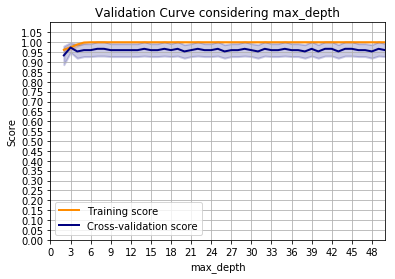

In [13]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
param_range = np.arange(2, 51, 1)
train_scores, test_scores = validation_curve(
    tree.DecisionTreeClassifier(class_weight = "balanced"), iris.data, iris.target, param_name = "max_depth", param_range = param_range,
    cv = 5, scoring = "accuracy", n_jobs = 1)
train_scores_mean = np.mean(train_scores, axis = 1)
train_scores_std = np.std(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis= 1)
test_scores_std = np.std(test_scores, axis = 1)

plt.title("Validation Curve considering max_depth")
plt.xlabel("max_depth")

plt.grid(True)
plt.xticks(np.arange(0,51,3))
plt.yticks(np.arange(0,1.1, 0.05))
plt.xlim(0, 50)
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label = "Training score",
             color = "darkorange", lw = lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color = "darkorange", lw = lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw = lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha = 0.2,
                 color = "navy", lw = lw)
plt.legend(loc = "best")
plt.show()

Considering different values for **min_samples_leaf** we can see from the validation curve that increasing **min_samples_leaf** until 37, the accuracy reamains more or less the same. After 37, the accuracy score decreases. Since we want a simple tree, we prefer to set **min_samples_leaf** to a higher value, so **min_samples_leaf** will be 37

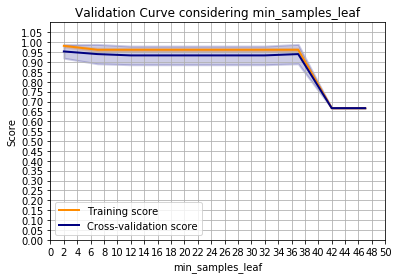

In [7]:
param_range = np.arange(2, 51, 5)
train_scores, test_scores = validation_curve(
    tree.DecisionTreeClassifier(class_weight = "balanced"), iris.data, iris.target, param_name = "min_samples_leaf", param_range = param_range,
    cv = 5, scoring = "accuracy", n_jobs = 1)
train_scores_mean = np.mean(train_scores, axis = 1)
train_scores_std = np.std(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis= 1)
test_scores_std = np.std(test_scores, axis = 1)

plt.title("Validation Curve considering min_samples_leaf")
plt.xlabel("min_samples_leaf")

plt.grid(True)
plt.xticks(np.arange(0,51,2))
plt.yticks(np.arange(0, 1.1, 0.05))
plt.xlim(0, 50)
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label = "Training score",
             color = "darkorange", lw = lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color = "darkorange", lw = lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw = lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha = 0.2,
                 color = "navy", lw = lw)
plt.legend(loc = "best")
plt.show()

Considering different values for **min_samples_split** we can see from the validation curve that increasing **min_samples_split** until 37, the accuracy reamains more or less the same. After 37, the accuracy score decreases a little bit, until 78. After this value the accuracy score decrases drammatically. Since we want simple tree, we prefer to set **min_samples_split** to a lower value, and we choose 37

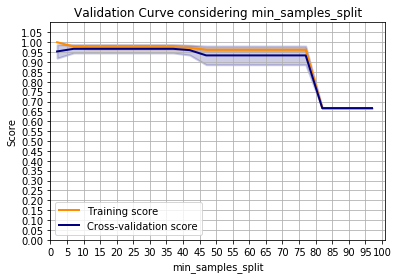

In [8]:
param_range = np.arange(2, 101, 5)
train_scores, test_scores = validation_curve(
    tree.DecisionTreeClassifier(class_weight = "balanced"), iris.data, iris.target, param_name = "min_samples_split", param_range = param_range,
    cv = 5, scoring = "accuracy", n_jobs = 1)
train_scores_mean = np.mean(train_scores, axis = 1)
train_scores_std = np.std(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis= 1)
test_scores_std = np.std(test_scores, axis = 1)

plt.title("Validation Curve considering min_samples_split")
plt.xlabel("min_samples_split")

plt.grid(True)
plt.xticks(np.arange(0,101,5))
plt.yticks(np.arange(0, 1.1, 0.05))
plt.xlim(0, 101)
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label = "Training score",
             color = "darkorange", lw = lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color = "darkorange", lw = lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw = lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha = 0.2,
                 color = "navy", lw = lw)
plt.legend(loc = "best")
plt.show()

This is the resulting tree using the hyperparameters based on the validation curves

Scores
[0.96666667 0.96666667 0.9        0.86666667 1.        ]


Mean of scores
0.9400000000000001


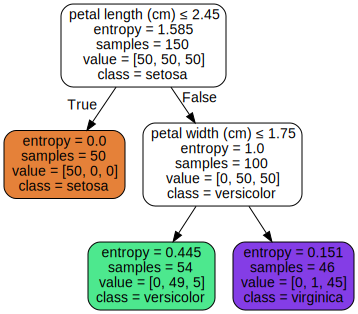

In [9]:
clf = tree.DecisionTreeClassifier(criterion="entropy", random_state=300, max_depth = 3, min_samples_split = 37, min_samples_leaf = 37, class_weight={0:1,1:1,2:1})
clf = clf.fit(iris.data, iris.target)
predicted_y_test = clf.predict(iris_X_test)
#we pass the classifier, the dataset, the target and the number of partitions 
#we have differents combinations of examples in training and test set
scores = cross_val_score(clf, iris.data, iris.target, cv=5) # score will be the accuracy of each permutation 
print("Scores")
print(scores)
print("\n")
print("Mean of scores")
print(np.mean(scores, dtype=np.float64))

#Showing tree
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names, 
                         class_names=iris.target_names, 
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

As result we have a decision tree with 94% of accuracy calculated considering CV. The first decision tree has 94.6% of accuracy, but it's more complex because it has more leaf nodes and it's deeper than the new one. 

## Build confusion matrix

Confusion matrix, without normalization
[[15  0  0]
 [ 0 14  1]
 [ 0  1 14]]


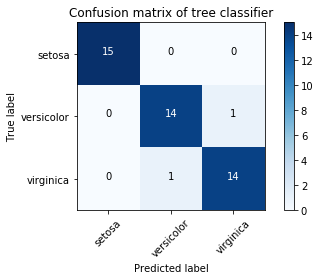

In [10]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#Split dataset and labels in training set and test set, with respectives labels
#iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(X, y, test_size=.3, random_state = 42)
class_names = iris.target_names
#clf.fit(iris_X_train, iris_y_train)
cnf_matrix_tree = confusion_matrix(iris_y_test, predicted_y_test)

plt.figure()
plot_confusion_matrix(cnf_matrix_tree, classes=class_names,
                      title='Confusion matrix of tree classifier')

## Build ROC curve

In [11]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

def roc_plot(classes, predicted, actual):
 
    fpr = {}
    tpr = {}
    roc = {}
    for i in range(0, len(classes)):
        fpr[i], tpr[i], _ = roc_curve(actual[:, i], predicted[:, i])
        roc[i] = auc(fpr[i], tpr[i])
        
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)
    
    fpr["m"] = all_fpr
    tpr["m"] = mean_tpr
    roc["m"] = auc(fpr["m"], tpr["m"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["m"], tpr["m"],label='ROC curve (area = {0:0.2f})'.format(roc["m"]),color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve for {0} (area = {1:0.2f})'.format(iris.target_names[i], roc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.legend(loc="lower right")
    plt.show()

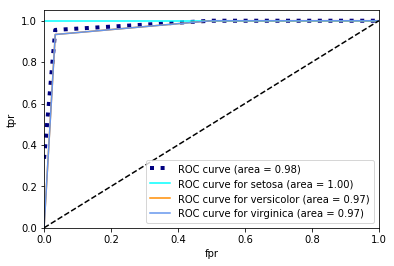

In [12]:
prob = clf.predict_proba(iris_X_test)

actual_prob = np.zeros((iris_y_test.size, 3))
for i,y in np.ndenumerate(iris_y_test):
    actual_prob[i,y] = 1


roc_plot(class_names, prob, actual_prob)